In [1]:
!pwd

/panda/eedy/iono-notebook


In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import h5py
import numpy as np
import os
import datetime as dt
import numpy as np
import math
from scipy import interpolate
from mintpy.objects import ionex, timeseries
from mintpy.simulation import iono
from mintpy.utils import readfile, writefile
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
from mintpy import iono_tec
from mintpy.cli import diff, ifgram_inversion, modify_network, reference_point, reference_date
from mintpy.utils import utils as ut
from tqdm import trange
import h5py

from datetime import datetime
from netCDF4 import Dataset
from mintpy.utils import ptime, readfile, writefile


In [3]:
tframe_left = gpd.read_file("/home/eedy/data/aux/tframe_orbit/tframe_left_look.gpkg")
tframe_left.crs = "EPSG:4326"
# 初始化列表
ascending_frame_time_date = []
ascending_frame_time_utc_sec = []
ascending_NearLookAngle = []
ascending_FarLookAngle = []
ascending_lat1 = []
ascending_lon1 = []
ascending_lat2 = []
ascending_lon2 = []
ascending_lat3 = []
ascending_lon3 = []
ascending_lat4 = []
ascending_lon4 = []

descending_frame_time_date = []
descending_frame_time_utc_sec = []
descending_latitude = []
descending_longitude = []
descending_NearLookAngle = []
descending_FarLookAngle = []
descending_lat1 = []
descending_lon1 = []
descending_lat2 = []
descending_lon2 = []
descending_lat3 = []
descending_lon3 = []
descending_lat4 = []
descending_lon4 = []

# 遍历 track_frame
for index, row in tframe_left.iterrows():
    # 获取日期和时间
    startET = row['startET']
    endET = row['endET']
    tcenter = (startET + endET)/2.0
    import datetime
    frame_time_utc = datetime.datetime(2000,1,1)+datetime.timedelta(seconds=tcenter)
    frame_time_date = frame_time_utc.date()
    frame_time_utc_sec = frame_time_utc.hour * 60 + frame_time_utc.minute + frame_time_utc.second / 60

    # 获取入射角
    swathNearLookAngle = row['swathNearLookAngle']
    swathFarLookAngle = row['swathFarLookAngle']

    polygon = row['geometry']
    exterior_coords = polygon.geoms[0].exterior.coords
    # 提取四个角点
    corners = [exterior_coords[0], exterior_coords[len(exterior_coords) // 4],exterior_coords[len(exterior_coords) // 2], exterior_coords[3 * len(exterior_coords) // 4]]
    ## 1:右下  2:左下  3:左上  4:右上
    ## 1\4:FarLookAngle  2\3:NearLookAngle

    lat1 = corners[0][1]
    lon1 = corners[0][0]
    lat2 = corners[1][1]
    lon2 = corners[1][0]
    lat3 = corners[2][1]
    lon3 = corners[2][0]
    lat4 = corners[3][1]
    lon4 = corners[3][0]
    
    
    # 根据 passDirection 来决定是 ascending 还是 descending
    pass_direction = row['passDirection']
    
    if pass_direction == 'Ascending':
        ascending_frame_time_date.append(frame_time_date)
        ascending_frame_time_utc_sec.append(frame_time_utc_sec)
        ascending_NearLookAngle.append(swathNearLookAngle)
        ascending_FarLookAngle.append(swathFarLookAngle)
        ascending_lat1.append(lat1)
        ascending_lon1.append(lon1)
        ascending_lat2.append(lat2)
        ascending_lon2.append(lon2)
        ascending_lat3.append(lat3)
        ascending_lon3.append(lon3)
        ascending_lat4.append(lat4)
        ascending_lon4.append(lon4)
        
    elif pass_direction == 'Descending':
        descending_frame_time_date.append(frame_time_date)
        descending_frame_time_utc_sec.append(frame_time_utc_sec)
        descending_NearLookAngle.append(swathNearLookAngle)
        descending_FarLookAngle.append(swathFarLookAngle)
        descending_lat1.append(lat1)
        descending_lon1.append(lon1)
        descending_lat2.append(lat2)
        descending_lon2.append(lon2)
        descending_lat3.append(lat3)
        descending_lon3.append(lon3)
        descending_lat4.append(lat4)
        descending_lon4.append(lon4)
    else:
        # 处理其他情况，如果有的话
        pass


In [10]:
r_iono_all_1 = []
r_iono_all_2 = []
r_iono_all_3 = []
r_iono_all_4 = []

for year in range(2010,2024):
    # 打开.h5文件进行读取
    with h5py.File(f'data/global_a/asc_iono_{year}.h5', 'r') as h5f:
        # 读取数据集
        r_iono_1 = h5f['r_iono_1'][:]
        r_iono_2 = h5f['r_iono_2'][:]
        r_iono_3 = h5f['r_iono_3'][:]
        r_iono_4 = h5f['r_iono_4'][:]

    r_iono_means_1 = []
    r_iono_means_2 = []
    r_iono_means_3 = []
    r_iono_means_4 = []

    # 检查子列表长度是否相同
    lengths = [len(sublist) for sublist in r_iono_1]
    for index in range(len(r_iono_1[0])):
        # 收集每个子列表对应索引的元素
        values = [sublist[index] for sublist in r_iono_1]
        # 计算均值，忽略 np.nan
        mean_value = np.nanmean(values)
        r_iono_means_1.append(mean_value)

    # 检查子列表长度是否相同
    lengths = [len(sublist) for sublist in r_iono_2]
    for index in range(len(r_iono_1[0])):
        # 收集每个子列表对应索引的元素
        values = [sublist[index] for sublist in r_iono_2]
        # 计算均值，忽略 np.nan
        mean_value = np.nanmean(values)
        r_iono_means_2.append(mean_value)

    # 检查子列表长度是否相同
    lengths = [len(sublist) for sublist in r_iono_3]
    for index in range(len(r_iono_1[0])):
        # 收集每个子列表对应索引的元素
        values = [sublist[index] for sublist in r_iono_3]
        # 计算均值，忽略 np.nan
        mean_value = np.nanmean(values)
        r_iono_means_3.append(mean_value)
    
    # 检查子列表长度是否相同
    lengths = [len(sublist) for sublist in r_iono_4]
    for index in range(len(r_iono_1[0])):
        # 收集每个子列表对应索引的元素
        values = [sublist[index] for sublist in r_iono_4]
        # 计算均值，忽略 np.nan
        mean_value = np.nanmean(values)
        r_iono_means_4.append(mean_value)

    r_iono_all_1.append(r_iono_means_1)
    r_iono_all_2.append(r_iono_means_2)
    r_iono_all_3.append(r_iono_means_3)
    r_iono_all_4.append(r_iono_means_4)

In [16]:
r_iono_means_1 = []
r_iono_means_2 = []
r_iono_means_3 = []
r_iono_means_4 = []

# 检查子列表长度是否相同
lengths = [len(sublist) for sublist in r_iono_all_1]
for index in range(len(r_iono_all_1[0])):
    # 收集每个子列表对应索引的元素
    values = [sublist[index] for sublist in r_iono_all_1]
    # 计算均值，忽略 np.nan
    mean_value = np.nanmean(values)
    r_iono_means_1.append(mean_value)

# 检查子列表长度是否相同
lengths = [len(sublist) for sublist in r_iono_all_2]
for index in range(len(r_iono_all_1[0])):
    # 收集每个子列表对应索引的元素
    values = [sublist[index] for sublist in r_iono_all_2]
    # 计算均值，忽略 np.nan
    mean_value = np.nanmean(values)
    r_iono_means_2.append(mean_value)

# 检查子列表长度是否相同
lengths = [len(sublist) for sublist in r_iono_all_3]
for index in range(len(r_iono_all_3[0])):
    # 收集每个子列表对应索引的元素
    values = [sublist[index] for sublist in r_iono_all_3]
    # 计算均值，忽略 np.nan
    mean_value = np.nanmean(values)
    r_iono_means_3.append(mean_value)

# 检查子列表长度是否相同
lengths = [len(sublist) for sublist in r_iono_all_4]
for index in range(len(r_iono_all_4[0])):
    # 收集每个子列表对应索引的元素
    values = [sublist[index] for sublist in r_iono_all_4]
    # 计算均值，忽略 np.nan
    mean_value = np.nanmean(values)
    r_iono_means_4.append(mean_value)

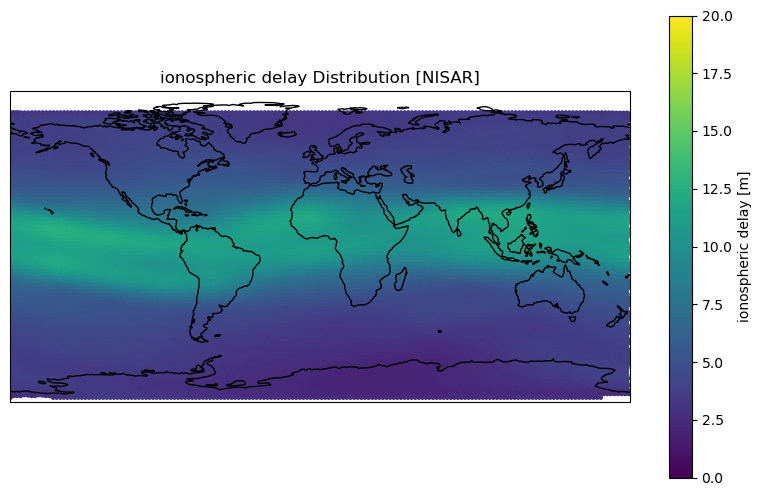

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 创建地图投影
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# 添加地形轮廓背景，仅画出黑色轮廓线
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# 绘制第一组数据
sc1 = ax.scatter(ascending_lon1, ascending_lat1, c=r_iono_means_1, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=0,vmax=20)
# 绘制第一组数据
sc2 = ax.scatter(ascending_lon2, ascending_lat2, c=r_iono_means_2, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=0,vmax=20)
# 绘制第一组数据
sc3 = ax.scatter(ascending_lon3, ascending_lat3, c=r_iono_means_3, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=0,vmax=20)
# 绘制第一组数据
sc4 = ax.scatter(ascending_lon4, ascending_lat4, c=r_iono_means_4, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=0,vmax=20)

# 设置横纵坐标范围
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# 创建一个共享的颜色条
cbar = plt.colorbar(sc1, label='ionospheric delay [m]')

plt.title('ionospheric delay Distribution [NISAR]')
plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 假设每组数据长度相同
n = len(ascending_lon1)

# 计算坡度和坡向
dx = []
dy = []
center_lon = []
center_lat = []

for i in range(n):
    # 获取四个端点的经纬度和值
    lon1, lat1, z1 = ascending_lon1[i], ascending_lat1[i], r_iono_means_1[i]
    lon2, lat2, z2 = ascending_lon2[i], ascending_lat2[i], r_iono_means_2[i]
    lon3, lat3, z3 = ascending_lon3[i], ascending_lat3[i], r_iono_means_3[i]
    lon4, lat4, z4 = ascending_lon4[i], ascending_lat4[i], r_iono_means_4[i]

    # 计算中心点的经纬度
    center_loni = (lon1 + lon2 + lon3 + lon4) / 4
    center_lati = (lat1 + lat2 + lat3 + lat4) / 4

    # 计算坡度和坡向
    dz_dx = ((z2 - z1) + (z4 - z3)) / 2
    dz_dy = ((z3 - z2) + (z4 - z1)) / 2
    
    center_lon.append(center_loni)
    center_lat.append(center_lati)
    dx.append(dz_dx)
    dy.append(dz_dy)

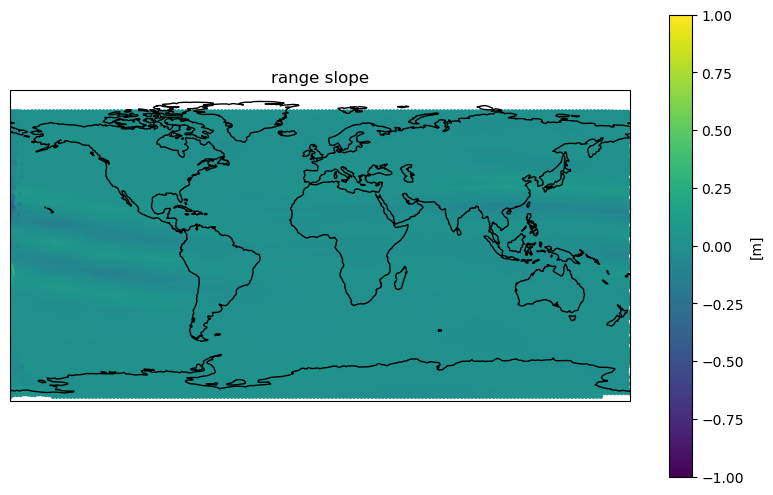

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 创建地图投影
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# 添加地形轮廓背景，仅画出黑色轮廓线
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# 绘制第一组数据
sc1 = ax.scatter(ascending_lon1, ascending_lat1, c=dx, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
# 绘制第一组数据
sc2 = ax.scatter(ascending_lon2, ascending_lat2, c=dx, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
# 绘制第一组数据
sc3 = ax.scatter(ascending_lon3, ascending_lat3, c=dx, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
# 绘制第一组数据
sc4 = ax.scatter(ascending_lon4, ascending_lat4, c=dx, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=-1,vmax=1)


# 设置横纵坐标范围
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# 创建一个共享的颜色条
cbar = plt.colorbar(sc1, label='[m]')

plt.title('range slope')
plt.show()

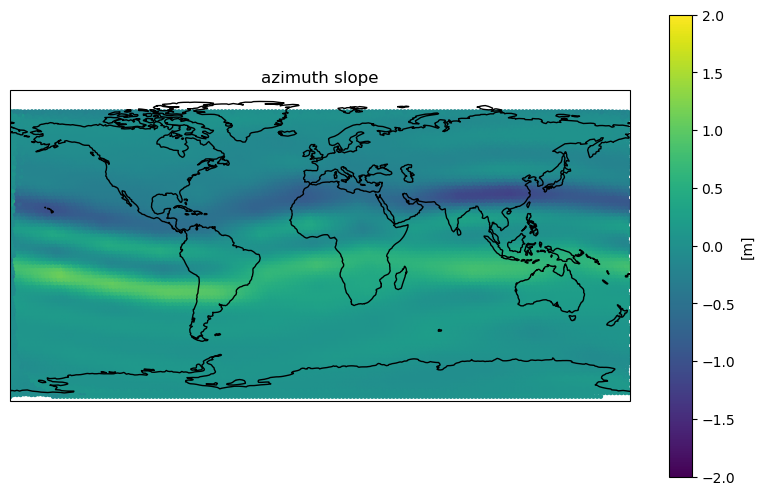

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 创建地图投影
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# 添加地形轮廓背景，仅画出黑色轮廓线
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# 绘制第一组数据
sc1 = ax.scatter(ascending_lon1, ascending_lat1, c=dy, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=-2,vmax=2)
# 绘制第一组数据
sc2 = ax.scatter(ascending_lon2, ascending_lat2, c=dy, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=-2,vmax=2)
# 绘制第一组数据
sc3 = ax.scatter(ascending_lon3, ascending_lat3, c=dy, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=-2,vmax=2)
# 绘制第一组数据
sc4 = ax.scatter(ascending_lon4, ascending_lat4, c=dy, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=-2,vmax=2)

# 设置横纵坐标范围
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# 创建一个共享的颜色条
cbar = plt.colorbar(sc1, label='[m]')

plt.title('azimuth slope')
plt.show()